# Stable Diffusion on AWS INF2
> 참조 : https://www.philschmid.de/inferentia2-stable-diffusion-xl
- 추가 참조 : https://github.com/aws/sagemaker-huggingface-inference-toolkit/tree/main
- 추가 참조 : https://github.com/huggingface/notebooks/blob/main/sagemaker/23_stable_diffusion_inference/sagemaker-notebook.ipynb
- optimum : https://huggingface.co/docs/optimum-neuron/index
  - optimum 자체가 Neuron 인줄 알았는데, optimum은 별도 운영체제를 가져 가고 있다.
  - optimum SDXL Tutorial : https://www.philschmid.de/inferentia2-stable-diffusion-xl
- SDXL : Finetune : https://github.com/aws-samples/finetune-sdxl-on-sagemaker-and-host-on-infr2


다음 URL의 참조 데이터는 실행이 안된다. 정확히는 Compile 하고, Deploy까지는 된다. 그러나, Inference 요청하면 runtime error (timeout)이 발생한다. 
- https://github.com/aws-neuron/aws-neuron-sagemaker-samples/blob/master/inference/stable-diffusion/StableDiffusion2_1.ipynb

왜 그럴까? 어떤 차이일까?

In [5]:
# Install the required packages
%pip install "optimum-neuron==0.0.13" "diffusers==0.21.4" --upgrade
%pip install "sagemaker>=2.197.0"  --upgrade

  Using cached optimum_neuron-0.0.13-py3-none-any.whl.metadata (14 kB)
  Using cached diffusers-0.21.4-py3-none-any.whl.metadata (18 kB)
  Using cached accelerate-0.23.0-py3-none-any.whl.metadata (18 kB)
  Using cached optimum-1.24.0-py3-none-any.whl.metadata (21 kB)
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached optimum_neuron-0.0.13-py3-none-any.whl (244 kB)
Using cached diffusers-0.21.4-py3-none-any.whl (1.5 MB)
Using cached accelerate-0.23.0-py3-none-any.whl (258 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
Using cached optimum-1.24.0-py3-none-any.whl (433 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
  Attempt

In [6]:
from huggingface_hub import snapshot_download
 
# compiled model id
compiled_model_id = "aws-neuron/stable-diffusion-xl-base-1-0-1024x1024"
 
# save compiled model to local directory
save_directory = "sdxl_neuron"
# Downloads our compiled model from the HuggingFace Hub
# using the revision as neuron version reference
# and makes sure we exlcude the symlink files and "hidden" files, like .DS_Store, .gitignore, etc.
snapshot_download(compiled_model_id, revision="2.15.0", local_dir=save_directory, local_dir_use_symlinks=False, allow_patterns=["[!.]*.*"])
 
 
###############################################
# COMMENT IN BELOW TO COMPILE DIFFERENT MODEL #
###############################################
#
# from optimum.neuron import NeuronStableDiffusionXLPipeline
#
# # model id you want to compile
# vanilla_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
#
# # configs for compiling model
# compiler_args = {"auto_cast": "all", "auto_cast_type": "bf16"}
# input_shapes = {
#   "height": 1024, # width of the image
#   "width": 1024, # height of the image
#   "num_images_per_prompt": 1, # number of images to generate per prompt
#   "batch_size": 1 # batch size for the model
#   }
#
# sd = NeuronStableDiffusionXLPipeline.from_pretrained(vanilla_model_id, export=True, **input_shapes, **compiler_args)
#
# # Save locally or upload to the HuggingFace Hub
# save_directory = "sdxl_neuron"
# sd.save_pretrained(save_directory)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

'/mnt/custom-file-systems/efs/fs-03939c261be80e548_fsap-09dd049f188e6ddf4/cocone/sdxl_test/sdxl_neuron'

In [7]:
%%writefile {save_directory}/code/inference.py
import os
# To use two neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "2"
import torch
import torch_neuronx
import base64
from io import BytesIO
from optimum.neuron import NeuronStableDiffusionXLPipeline
 
 
def model_fn(model_dir):
    # load local converted model into pipeline
    pipeline = NeuronStableDiffusionXLPipeline.from_pretrained(model_dir, device_ids=[0, 1])
    return pipeline
 
 
def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)
 
    parameters = data.pop("parameters", None)
 
    if parameters is not None:
        generated_images = pipeline(prompt, **parameters)["images"]
    else:
        generated_images = pipeline(prompt)["images"]
 
    # postprocess convert image into base64 string
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())
 
    # always return the first
    return {"generated_images": encoded_images}

Overwriting sdxl_neuron/code/inference.py


In [8]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
 
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']
 
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
 
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
assert sess.boto_region_name in ["us-east-2", "us-east-1", "us-west-2"] , "region must be us-east-2 or us-west-2, due to instance availability"

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::396608815783:role/service-role/AmazonSageMaker-ExecutionRole-20250207T102425
sagemaker bucket: sagemaker-us-west-2-396608815783
sagemaker session region: us-west-2


In [9]:
# create code directory in our model directory
!mkdir {save_directory}/code

mkdir: cannot create directory ‘sdxl_neuron/code’: File exists


In [10]:
%%writefile {save_directory}/code/inference.py
import os
# To use two neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "2"
import torch
import torch_neuronx
import base64
from io import BytesIO
from optimum.neuron import NeuronStableDiffusionXLPipeline
 
 
def model_fn(model_dir):
    # load local converted model into pipeline
    pipeline = NeuronStableDiffusionXLPipeline.from_pretrained(model_dir, device_ids=[0, 1])
    return pipeline
 
 
def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)
 
    parameters = data.pop("parameters", None)
 
    if parameters is not None:
        generated_images = pipeline(prompt, **parameters)["images"]
    else:
        generated_images = pipeline(prompt)["images"]
 
    # postprocess convert image into base64 string
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())
 
    # always return the first
    return {"generated_images": encoded_images}

Overwriting sdxl_neuron/code/inference.py


In [11]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
 
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']
 
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
 
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
assert sess.boto_region_name in ["us-east-2", "us-east-1", "us-west-2"] , "region must be us-east-2 or us-west-2, due to instance availability"

sagemaker role arn: arn:aws:iam::396608815783:role/service-role/AmazonSageMaker-ExecutionRole-20250207T102425
sagemaker bucket: sagemaker-us-west-2-396608815783
sagemaker session region: us-west-2


In [ ]:
# create a model.tar.gz archive with all the model artifacts and the inference.py script.
# %cd {save_directory}
# !tar zcvf model.tar.gz *
# %cd ..

/mnt/custom-file-systems/efs/fs-03939c261be80e548_fsap-09dd049f188e6ddf4/cocone/sdxl_test/sdxl_neuron
README.md
code/
code/.ipynb_checkpoints/
code/.ipynb_checkpoints/inference-checkpoint.py
code/inference.py
model.tar.gz
model_index.json
scheduler/
scheduler/scheduler_config.json
text_encoder/
text_encoder/model.neuron
text_encoder/config.json
text_encoder_2/
text_encoder_2/model.neuron
unet/config.json
vae_decoder/
vae_decoder/model.neuron
vae_decoder/config.json
vae_encoder/
vae_encoder/model.neuron
vae_encoder/config.json
/mnt/custom-file-systems/efs/fs-03939c261be80e548_fsap-09dd049f188e6ddf4/cocone/sdxl_test


In [ ]:
from sagemaker.s3 import S3Uploader
 
# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/neuronx/sdxl"
 
# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path=f"{save_directory}/model.tar.gz", desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

model artifcats uploaded to s3://sagemaker-us-west-2-396608815783/neuronx/sdxl/model.tar.gz


In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel
 
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,        # path to your model.tar.gz on s3
   role=role,                      # iam role with permissions to create an Endpoint
   transformers_version="4.34.1",  # transformers version used
   pytorch_version="1.13.1",       # pytorch version used
   py_version='py310',             # python version used
   model_server_workers=1,         # number of workers for the model server
)
 
# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # number of instances
    instance_type="ml.inf2.8xlarge", # AWS Inferentia Instance
    volume_size = 100
)
# ignore the "Your model is not compiled. Please compile your model before using Inferentia." warning, we already compiled our model.

[04/22/25 11:28:52] WARNING  Your model is not compiled. Please compile your model before using       ]8;id=364737;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=889691;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#1598\1598]8;;\
                             Inferentia.                                                                           

                    INFO     Creating model with name:                                              ]8;id=148832;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=614348;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\
                             huggingface-pytorch-inference-neuronx-2025-04-22-11-28-52-970                         

[04/22/25 11:28:53] INFO     Creating endpoint-config with name                                     ]8;id=381139;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=427999;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#6019\6019]8;;\
                             huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685                         

[04/22/25 11:28:54] INFO     Creating endpoint with name                                            ]8;id=125085;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=717788;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4841\4841]8;;\
                             huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685                         

-------------!

# Inference / Generate Images using the deployed model

In [22]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64
 
# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return Image.open(buffer)
 
# display PIL images as grid
def display_image(image=None,width=500,height=500):
    img = image.resize((width, height))
    display(img)

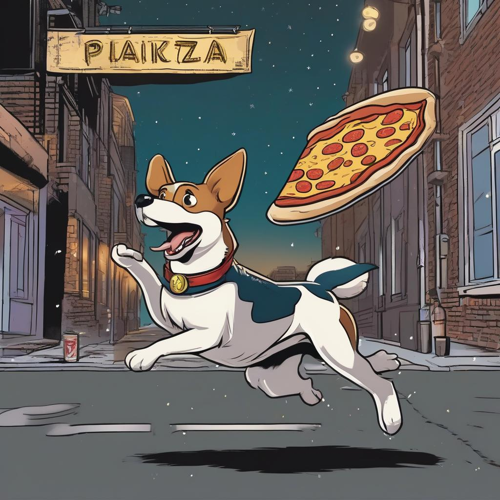

In [23]:
prompt = "A dog trying catch a flying pizza at a street corner, comic book, well lit, night time"
 
# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
    "num_inference_steps" : 25,
    "negative_prompt" : "disfigured, ugly, deformed"
    }
  }
)
 
# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))

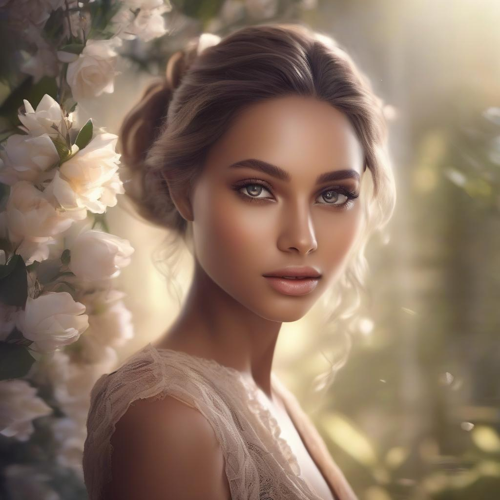

In [24]:
prompt_image_pos = "portrait of a beautiful person, smooth and flawless skin, realistic eyelashes, relaxed expression, photorealistic, soft natural lighting, glowing complexion, high detail eyes, serene atmosphere"
prompt_image_neg = "blackheads, large pores, skin texture, facial hair, no eyelashes, frown, angry face, squinting eyes, distorted mouth, asymmetry, blemishes, wrinkles, creepy smile, dull skin, mustache"


# run prediction
response = predictor.predict(data={
  "inputs": prompt_image_pos,
  "parameters": {
    "num_inference_steps" : 25,
    "negative_prompt" : prompt_image_neg
    }
  }
)
 
# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))

In [25]:
from PIL import Image

init_image = Image.open("sample_image_M_40_01.png").convert("RGB")
init_image = init_image.resize((512, 512))  # 모델에 맞게 크기 조정

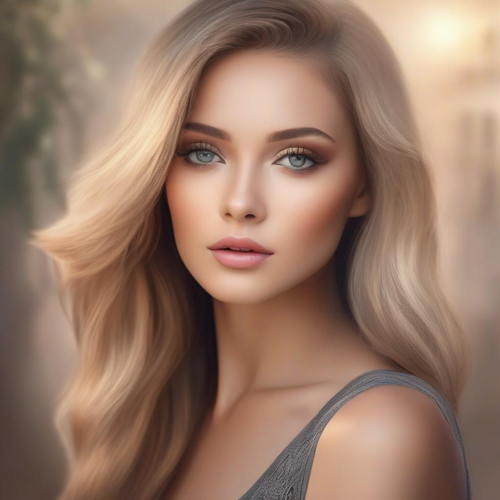

In [26]:
prompt_image_pos = "portrait of a beautiful person, smooth and flawless skin, realistic eyelashes, relaxed expression, photorealistic, soft natural lighting, glowing complexion, high detail eyes, serene atmosphere"
prompt_image_neg = "blackheads, large pores, skin texture, facial hair, no eyelashes, frown, angry face, squinting eyes, distorted mouth, asymmetry, blemishes, wrinkles, creepy smile, dull skin, mustache"


# run prediction
response = predictor.predict(data={
  "inputs": prompt_image_pos,
  "parameters": {
    "num_inference_steps" : 25,
    "negative_prompt" : prompt_image_neg
    }
  }
)
 
# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))

In [27]:
predictor

In [30]:
import boto3

def list_sagemaker_endpoints(region_name='us-west-2'):
    """
    현재 AWS 계정에 배포된 모든 SageMaker 엔드포인트 목록을 반환합니다.

    Args:
        region_name (str): AWS 리전 이름 (기본값: 'us-east-1')

    Returns:
        list: 엔드포인트 이름 목록
    """
    # SageMaker 클라이언트 생성
    sagemaker_client = boto3.client('sagemaker', region_name=region_name)

    # 엔드포인트 목록 조회
    response = sagemaker_client.list_endpoints()

    # 엔드포인트 이름 추출
    endpoints = [endpoint['EndpointName'] for endpoint in response['Endpoints']]

    return endpoints

In [34]:
list_endpoint = list_sagemaker_endpoints()
list_endpoint

['huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685',
 'basic-jumpstart-deploy-llama3-2-1b-01']

In [40]:
prompt_image_pos

'portrait of a beautiful person, smooth and flawless skin, realistic eyelashes, relaxed expression, photorealistic, soft natural lighting, glowing complexion, high detail eyes, serene atmosphere'

In [53]:
import boto3
import base64
from PIL import Image
import io
import json

# SageMaker 엔드포인트 이름
endpoint_name = list_endpoint[0]
print(endpoint_name)

# AWS 클라이언트 생성
runtime = boto3.client("sagemaker-runtime")

# 초기 이미지 로드 및 인코딩
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# 초기 이미지 경로
init_image_path = "sample_image_M_40_01.png"
encoded_image = encode_image(init_image_path)

# 요청 데이터 생성
# payload = {
#     "prompt": prompt_image_pos,
#     # "init_image": encoded_image,  # Base64로 인코딩된 이미지
#     "width": 512,
#     "height": 512,
#     "num_inference_steps": 20,
#     "guidance_scale": 7.5,
#     "strength": 0.1  # 원본 이미지와의 유사성 조정 (0: 원본 유지, 1: 완전 변경)
# }

payload = {
    "inputs": prompt_image_pos,
    "parameters": {
        "num_inference_steps" : 25,
        "negative_prompt" : prompt_image_neg
        # "width": 512,
        # "height": 512,
        # "num_inference_steps": 20,
        # "guidance_scale": 7.5,
        # "strength": 0.1
    }
}

# SageMaker 엔드포인트로 요청 전송
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Body=json.dumps(payload)
)

# 응답 처리
result = json.loads(response["Body"].read().decode())
# generated_image_data = base64.b64decode(result["generated_image"])
generated_image_data = base64.b64decode(result.get('generated_images')[0])

# 결과 이미지 저장
output_path = "output_image.jpg"
with open(output_path, "wb") as out_file:
    out_file.write(generated_image_data)

print(f"Generated image saved to {output_path}")


huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685
Generated image saved to output_image.jpg


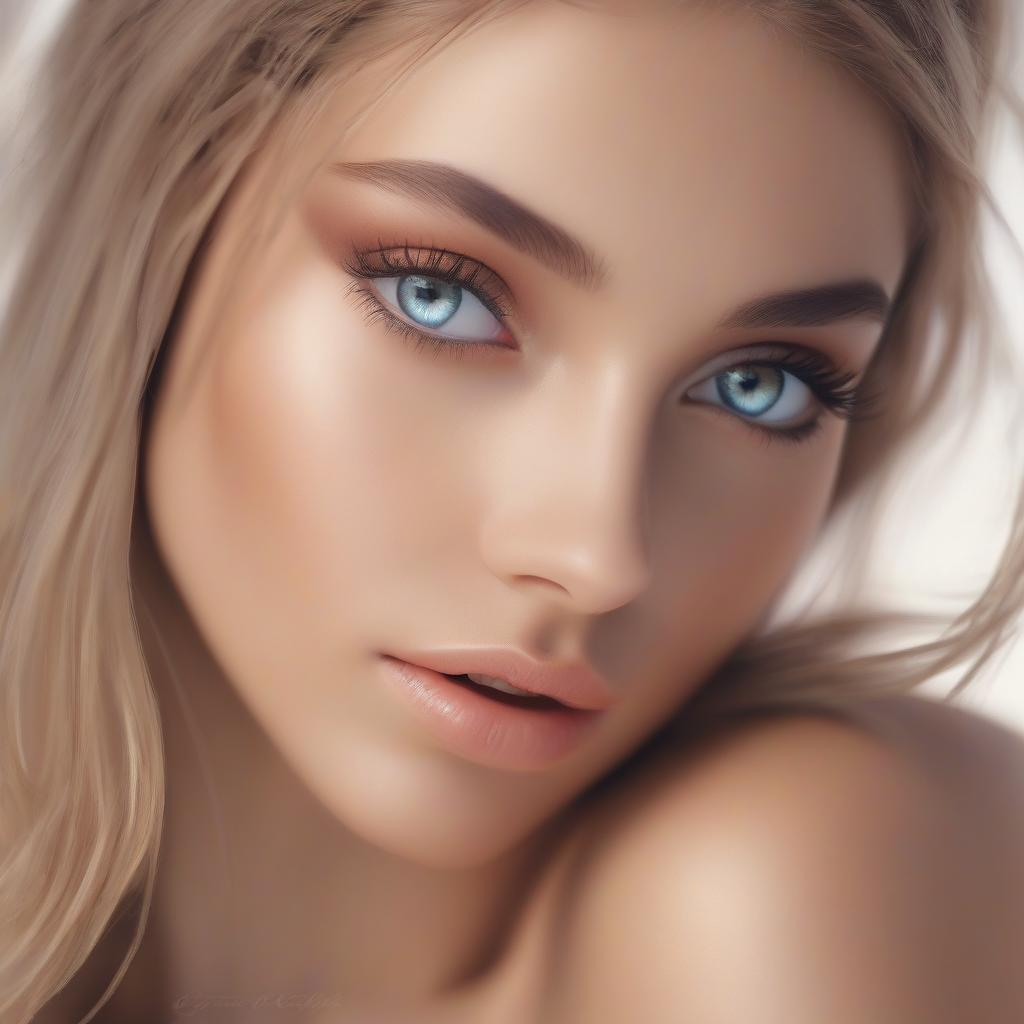

In [54]:
Image.open(output_path)

In [51]:
import base64
from PIL import Image
import io


def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")




def encode_image_with_resize(image_path):
    # 이미지 열기
    with Image.open(image_path) as img:
        # 원본 이미지 크기 가져오기
        width, height = img.size

        # 64의 배수로 조정할 새 크기 계산
        new_width = ((width + 63) // 64) * 64  # 올림하여 64의 배수로 만듦
        new_height = ((height + 63) // 64) * 64  # 올림하여 64의 배수로 만듦

        # 이미지 크기가 이미 64의 배수인지 확인
        if width != new_width or height != new_height:
            print(f"이미지 크기 조정: {width}x{height} -> {new_width}x{new_height}")
            # 이미지 크기 조정 (리샘플링 방법: LANCZOS는 고품질 다운샘플링에 적합)
            img = img.resize((new_width, new_height), Image.LANCZOS)
        else:
            print(f"이미지 크기 이미 64의 배수: {width}x{height}")

        # 이미지를 바이트로 변환
        buffer = io.BytesIO()
        img.save(buffer, format=img.format if img.format else "PNG")
        img_bytes = buffer.getvalue()

        # base64로 인코딩
        return base64.b64encode(img_bytes).decode("utf-8")


In [ ]:
prompt = "A dog trying catch a flying pizza at a street corner, comic book, well lit, night time"
 
# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
      "image": encode_image_with_resize("sample_image_M_40_01.png"),
      "strength": 0.1,
      "num_inference_steps" : 25,
      "negative_prompt" : "disfigured, ugly, deformed"
    }
  }
)
 
# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))